In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

csv = pd.read_csv("./datacollection/data.csv")
df = pd.DataFrame(csv)
df_time_offset = df["Timestamp"][0]
df["Timestamp"] = df["Timestamp"] - df_time_offset
df

,Timestamp,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,0.000000,-0.084796,-0.674117,-0.735678,-1.366999,-1.519680,-4.383240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.010000,-0.091138,-0.671366,-0.742551,-0.133216,-1.948935,-2.270379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.020000,-0.093359,-0.666888,-0.738602,0.794230,-2.261687,-2.150473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.030000,-0.094423,-0.670879,-0.740025,2.066061,-1.292022,-2.388483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.040000,-0.095000,-0.663934,-0.742627,1.157724,-1.248631,-1.990315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,59.129999,-0.394300,-0.595676,-0.488051,17.142166,46.378742,56.912491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,59.139997,-0.373628,-0.457209,-0.587035,-33.399334,65.561394,70.082047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,59.149999,-0.441235,-0.515912,-0.849490,9.406194,80.174103,87.021309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,59.159998,-0.432770,-0.619310,-0.699674,43.116070,75.518250,86.736839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[[0.0, 8.6, 0], [10.36, 21.08, 1], [21.96, 30.8, 2], [32.72, 41.24, 3], [43.88, 51.52, 4], [52.52, 58.64, 0]]


<AxesSubplot:xlabel='Timestamp', ylabel='Pose'>

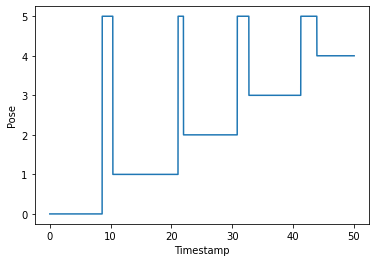

In [2]:
POSE_MAP= {
    "rett": 0,
    "framover": 1,
    "bakover": 2,
    "venstre": 3,
    "hoyre": 4
}

def get_timestamp_and_pose(filename):
    rows = []
    with open(filename, "r") as f:
        lines = f.readlines()
        offset = float(lines[1].strip().split(";")[1]) # This offset is the duration spent in the video before recording of data begun.
        for l in lines[1:]:
            sep_row = l.strip().split(";")
            finished_row = [round(float(x)-offset,2) for x in sep_row[1:3]]
            finished_row.append(POSE_MAP[sep_row[3].lower()])
            rows.append(finished_row)
    return rows
            

f_name = "../data/simon_data_2.txt"
stamped_poses = get_timestamp_and_pose(f_name)
print(stamped_poses)

df_stamped_poses = []
index = 0
for stamp in df["Timestamp"]:  
    pose_id = -1
    if stamp <= stamped_poses[-1][1]: 
        if stamp > stamped_poses[index][1]:
            index += 1
        pose_id = stamped_poses[index][2]
        # If timestamp is in new index, but haven't reached the starting time of this interval yet, set pose_id to default value 5.
        if stamp < stamped_poses[index][0]:
            pose_id = 5
    # If timestamp of the data point exceeds last timestamp recorded by the annotation, append default -1 value
    df_stamped_poses.append(pose_id)

#print(df_stamped_poses)

df["Pose"] = df_stamped_poses
#print(df[2400:2500][:])

#df['Pose'].hist(bins=4)
sns.lineplot(data=df, x="Timestamp", y='Pose')


